# Model

Import all needed in this notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import torch.nn.functional as F

2025-01-29 12:36:24.838034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 12:36:24.960292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 12:36:25.623187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-29 12:36:25.623245

## Model Creation

Create custom model

In [2]:
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512) 
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

num_classes = 2
custom_model = CustomCNNModel(num_classes=num_classes)

In [3]:
# for name, param in custom_model.named_parameters():
#     if "conv2" in name: 
#         param.requires_grad = False
#     else:
#         param.requires_grad = True

Print the structure of the model

In [4]:
print(custom_model)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Print frozen and trainable parameters of model

In [5]:
for name, param in custom_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

conv1.weight: Trainable
conv1.bias: Trainable
conv2.weight: Trainable
conv2.bias: Trainable
conv3.weight: Trainable
conv3.bias: Trainable
fc1.weight: Trainable
fc1.bias: Trainable
fc2.weight: Trainable
fc2.bias: Trainable
fc3.weight: Trainable
fc3.bias: Trainable


## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [6]:
# with zipfile.ZipFile("data.zip", 'r') as zip_ref:
#     zip_ref.extractall("")

In [7]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root="data", transform=transform)

class_indices = {class_name: [] for class_name in dataset.classes}
for idx, (image, label) in enumerate(dataset):
    class_indices[dataset.classes[label]].append(idx)

for x in class_indices:
    print(f"{x}: {len(class_indices[x])} images")

train_indices = []
test_indices = []

for class_name in dataset.classes:
    indices = class_indices[class_name]
    train_indices.extend(indices[:int(len(indices)*.75)])
    test_indices.extend(indices[int(len(indices)*.75):len(indices)-1])

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

normal: 1323 images
pneumonia: 1323 images


In [8]:
print(dataset.class_to_idx)

{'normal': 0, 'pneumonia': 1}


In [9]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1984
Test dataset size: 660


In [10]:
from collections import Counter

def count_classes_in_subset(subset, original_dataset):
    subset_labels = [original_dataset.targets[idx] for idx in subset.indices]
    class_counts = Counter(subset_labels)
    class_name_counts = {original_dataset.classes[idx]: count for idx, count in class_counts.items()}
    return class_name_counts

train_class_counts = count_classes_in_subset(train_dataset, dataset)
test_class_counts = count_classes_in_subset(test_dataset, dataset)

print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)

Train class counts: {'normal': 992, 'pneumonia': 992}
Test class counts: {'normal': 330, 'pneumonia': 330}


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break 

Batch X shape: torch.Size([32, 3, 224, 224]), batch y shape: torch.Size([32])


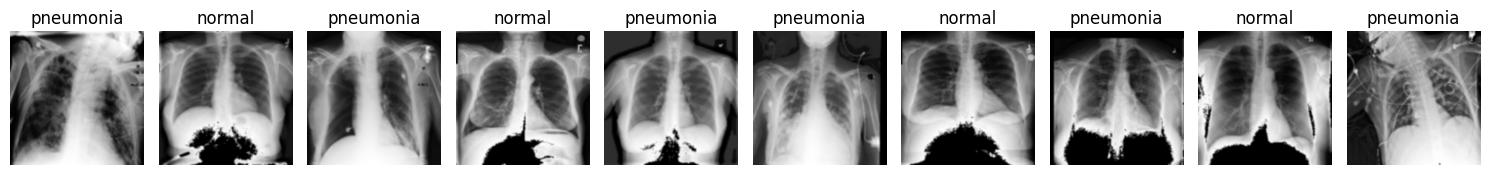

In [12]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1) 
        img = transforms.functional.to_pil_image(images[i])  
        plt.imshow(img)
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch in train_loader:
    X_batch, y_batch = batch
    class_names = dataset.classes
    display_images(X_batch[:10], y_batch[:10].tolist(), class_names)
    break

## Model Training And Evaluation

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [14]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"Device using for training: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{num_epochs}]") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=5e-5, weight_decay=5e-3)
# optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

num_epochs = 25
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(custom_model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

Device using for training: cuda


Epoch [1/25]: 100%|██████████| 62/62 [00:12<00:00,  5.11batch/s]


Epoch [1/25], Train Loss: 0.6918, Train Accuracy: 51.81%, Test Loss: 0.6678, Test Accuracy: 65.76%


Epoch [2/25]: 100%|██████████| 62/62 [00:10<00:00,  5.89batch/s]


Epoch [2/25], Train Loss: 0.6587, Train Accuracy: 62.20%, Test Loss: 0.6143, Test Accuracy: 67.58%


Epoch [3/25]: 100%|██████████| 62/62 [00:10<00:00,  6.06batch/s]


Epoch [3/25], Train Loss: 0.6516, Train Accuracy: 61.90%, Test Loss: 0.6051, Test Accuracy: 70.00%


Epoch [4/25]: 100%|██████████| 62/62 [00:10<00:00,  5.98batch/s]


Epoch [4/25], Train Loss: 0.6438, Train Accuracy: 64.11%, Test Loss: 0.5945, Test Accuracy: 69.85%


Epoch [5/25]: 100%|██████████| 62/62 [00:10<00:00,  5.84batch/s]


Epoch [5/25], Train Loss: 0.6365, Train Accuracy: 65.57%, Test Loss: 0.5873, Test Accuracy: 71.21%


Epoch [6/25]: 100%|██████████| 62/62 [00:10<00:00,  6.02batch/s]


Epoch [6/25], Train Loss: 0.6343, Train Accuracy: 65.52%, Test Loss: 0.5812, Test Accuracy: 71.82%


Epoch [7/25]: 100%|██████████| 62/62 [00:10<00:00,  6.09batch/s]


Epoch [7/25], Train Loss: 0.6302, Train Accuracy: 65.57%, Test Loss: 0.5799, Test Accuracy: 70.45%


Epoch [8/25]: 100%|██████████| 62/62 [00:10<00:00,  5.98batch/s]


Epoch [8/25], Train Loss: 0.6230, Train Accuracy: 66.94%, Test Loss: 0.5857, Test Accuracy: 70.45%


Epoch [9/25]: 100%|██████████| 62/62 [00:10<00:00,  5.86batch/s]


Epoch [9/25], Train Loss: 0.6243, Train Accuracy: 65.83%, Test Loss: 0.5962, Test Accuracy: 70.91%


Epoch [10/25]: 100%|██████████| 62/62 [00:10<00:00,  6.00batch/s]


Epoch [10/25], Train Loss: 0.6140, Train Accuracy: 67.64%, Test Loss: 0.5925, Test Accuracy: 70.00%


Epoch [11/25]: 100%|██████████| 62/62 [00:10<00:00,  6.06batch/s]


Epoch [11/25], Train Loss: 0.6109, Train Accuracy: 66.78%, Test Loss: 0.5720, Test Accuracy: 71.52%


Epoch [12/25]: 100%|██████████| 62/62 [00:10<00:00,  5.96batch/s]


Epoch [12/25], Train Loss: 0.6050, Train Accuracy: 68.20%, Test Loss: 0.5808, Test Accuracy: 71.82%


Epoch [13/25]: 100%|██████████| 62/62 [00:10<00:00,  6.07batch/s]


Epoch [13/25], Train Loss: 0.5934, Train Accuracy: 68.70%, Test Loss: 0.5747, Test Accuracy: 71.82%


Epoch [14/25]: 100%|██████████| 62/62 [00:10<00:00,  6.10batch/s]


Epoch [14/25], Train Loss: 0.5870, Train Accuracy: 69.35%, Test Loss: 0.5829, Test Accuracy: 70.61%


Epoch [15/25]: 100%|██████████| 62/62 [00:10<00:00,  6.12batch/s]


Epoch [15/25], Train Loss: 0.5822, Train Accuracy: 69.30%, Test Loss: 0.5874, Test Accuracy: 69.85%


Epoch [16/25]: 100%|██████████| 62/62 [00:10<00:00,  5.98batch/s]


Epoch [16/25], Train Loss: 0.5753, Train Accuracy: 70.31%, Test Loss: 0.6021, Test Accuracy: 67.58%


Epoch [17/25]: 100%|██████████| 62/62 [00:10<00:00,  5.98batch/s]


Epoch [17/25], Train Loss: 0.5666, Train Accuracy: 71.52%, Test Loss: 0.5766, Test Accuracy: 71.52%


Epoch [18/25]: 100%|██████████| 62/62 [00:10<00:00,  6.09batch/s]


Epoch [18/25], Train Loss: 0.5562, Train Accuracy: 72.18%, Test Loss: 0.5813, Test Accuracy: 71.06%


Epoch [19/25]: 100%|██████████| 62/62 [00:10<00:00,  6.14batch/s]


Epoch [19/25], Train Loss: 0.5512, Train Accuracy: 72.28%, Test Loss: 0.5815, Test Accuracy: 71.21%


Epoch [20/25]: 100%|██████████| 62/62 [00:10<00:00,  6.19batch/s]


Epoch [20/25], Train Loss: 0.5450, Train Accuracy: 72.98%, Test Loss: 0.5845, Test Accuracy: 71.21%


Epoch [21/25]: 100%|██████████| 62/62 [00:10<00:00,  6.05batch/s]


Epoch [21/25], Train Loss: 0.5384, Train Accuracy: 73.24%, Test Loss: 0.5816, Test Accuracy: 70.91%


Epoch [22/25]: 100%|██████████| 62/62 [00:10<00:00,  6.09batch/s]


Epoch [22/25], Train Loss: 0.5369, Train Accuracy: 73.59%, Test Loss: 0.5852, Test Accuracy: 71.21%


Epoch [23/25]: 100%|██████████| 62/62 [00:10<00:00,  5.89batch/s]


Epoch [23/25], Train Loss: 0.5311, Train Accuracy: 74.60%, Test Loss: 0.5792, Test Accuracy: 70.76%


Epoch [24/25]: 100%|██████████| 62/62 [00:10<00:00,  5.96batch/s]


Epoch [24/25], Train Loss: 0.5294, Train Accuracy: 74.75%, Test Loss: 0.5817, Test Accuracy: 71.52%


Epoch [25/25]: 100%|██████████| 62/62 [00:10<00:00,  5.91batch/s]


Epoch [25/25], Train Loss: 0.5281, Train Accuracy: 74.65%, Test Loss: 0.5794, Test Accuracy: 71.67%


## Model Evaluation

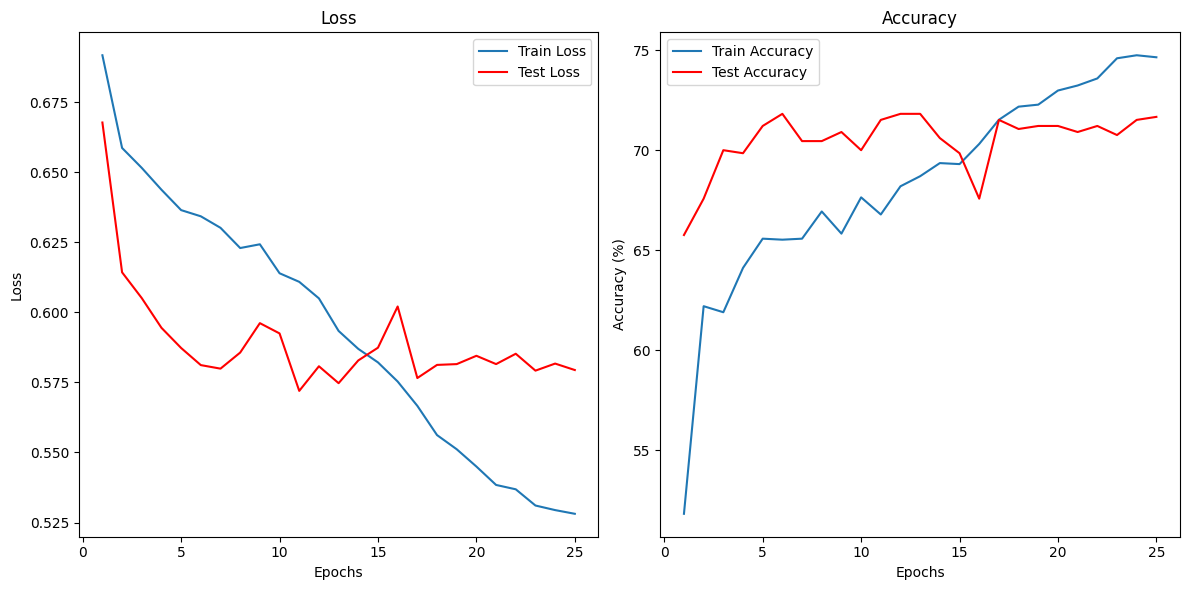

In [16]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss", color="r")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", color="r")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## Model Saving

In [17]:
model_name = "modelv5.1"

In [18]:
torch.save(custom_model.state_dict(), f"{model_name}.pth")

In [19]:
with zipfile.ZipFile(f"{model_name}.zip", 'w') as zipf:
        zipf.write(f"{model_name}.pth", arcname=f"{model_name}.pth")

## Model Evaluation

In [20]:
custom_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = custom_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7167
Precision: 0.7184
Recall: 0.7167
F1 Score: 0.7161
